# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 18.02.2025

Мягкий дедлайн: 11.03.2025 23:59 MSK

Жёсткий дедлайн: 16.03.2025 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [ ]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [ ]:
L = np.load('L.npy')
n, m = L.shape

In [ ]:
L

array([[1, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [ ]:
L.shape

(2000, 20)

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои.

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

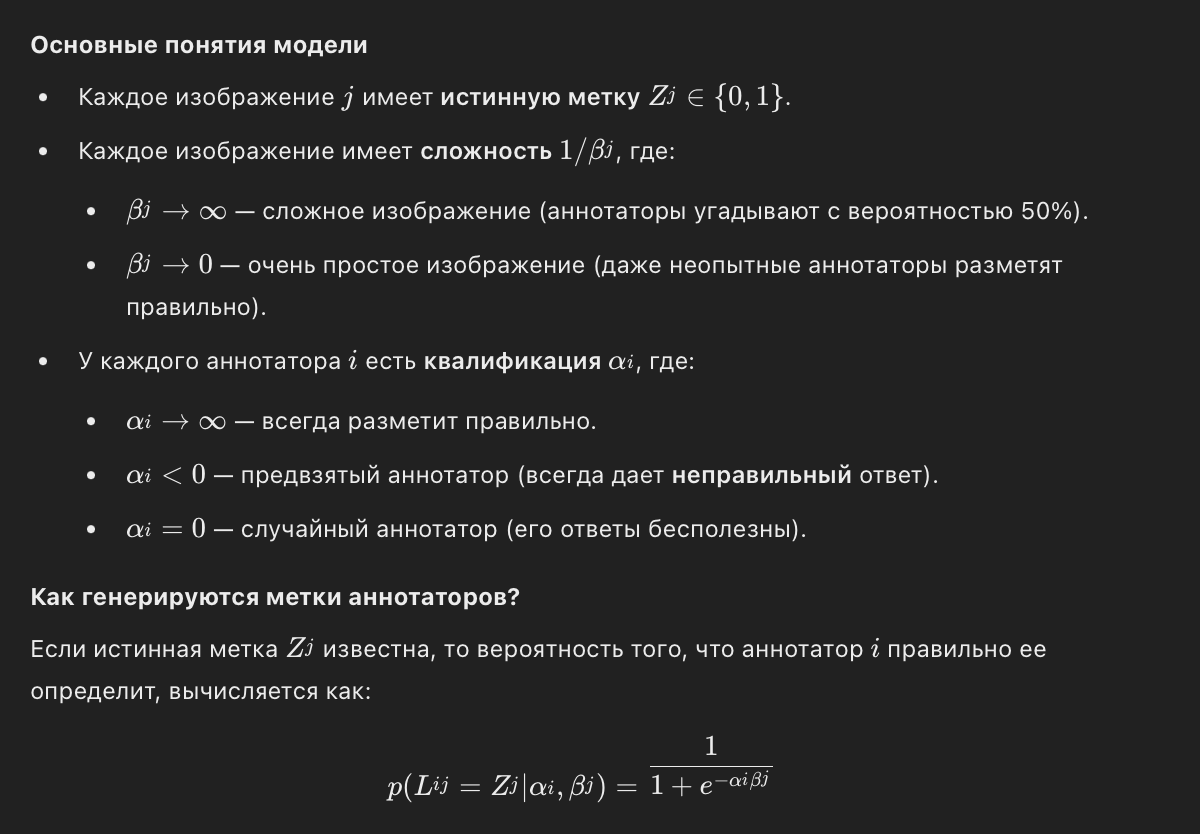

In [ ]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [ ]:
from scipy.special import softmax, expit
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    s = alpha[None, :]*beta[:, None]
    # если истинная метка Zj = 0
    log_p0 = np.sum(np.where(L == 0, -softplus(-s), -softplus(s)), axis = 1) + np.log(0.5) # сумма для всех критиков
    # если истинная метка Zj = 1
    log_p1 = np.sum(np.where(L==1, -softplus(-s), -softplus(s)), axis = 1) + np.log(0.5)
    log_joint = np.stack((log_p0, log_p1), axis=1)
    return softmax(log_joint, axis = 1)

def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    """
    s = alpha[None, :]*beta[:, None]
    mask = L == z[:, None]
    log_probs = np.where(mask, -softplus(-s), -softplus(s))
    return np.sum(log_probs)

def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    s = alpha[None, :]*beta[:, None]
    grad_s = np.where(L == 1, q[:, 1][:, None] - expit(s), q[:, 0][:, None] - expit(s))
    grad_alpha = np.sum(beta[:, None] * grad_s, axis=0)
    return grad_alpha


def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    s = alpha[None, :]*beta[:, None]
    grad_s = np.where(L == 1, q[:, 1][:, None] - expit(s), q[:, 0][:, None] - expit(s))
    grad_beta = np.sum(alpha[None, :] * grad_s, axis=1)
    return grad_beta


def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    s = alpha[None, :]*beta[:, None]
    log_p0 = np.sum(np.where(L == 0, -softplus(-s), -softplus(s)), axis = 1)
    log_p1 = np.sum(np.where(L == 1, -softplus(-s), -softplus(s)), axis = 1)
    entropy_q = - np.sum(q * np.log(q + 1e-10))
    lower_bound_value = np.sum(q[:, 0] * (log_p0 + np.log(0.5)) + q[:, 1] * (log_p1 + np.log(0.5))) + entropy_q
    return lower_bound_value

def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    m = L.shape[1]  # количество экспертов
    n = L.shape[0]  # количество задач
    alpha, logbeta = np.random.randn(m), np.random.randn(n)

    q = np.ones((n, 2)) * 0.5
    for step in range(n_steps):
        # E-step
        q = posterior(alpha, np.exp(logbeta), L)
        # M-step
        alpha_grad = alpha_grad_lb(alpha, np.exp(logbeta), L, q)
        logbeta_grad = logbeta_grad_lb(alpha, np.exp(logbeta), L, q)
        alpha += lr * alpha_grad
        logbeta += lr * logbeta_grad
        if step % 30 == 0:
          lb_val = lower_bound(alpha, np.exp(logbeta), L, q)
          print(f"iter={step}, lower_bound={lb_val:.3f}")
    return alpha, np.exp(logbeta), q

In [ ]:
alpha, beta, q = em(L)
alpha, beta, q

iter=0, lower_bound=-30911.607
iter=30, lower_bound=-22325.721
iter=60, lower_bound=-21452.035
iter=90, lower_bound=-20589.955
iter=120, lower_bound=-19796.188
iter=150, lower_bound=-19103.556
iter=180, lower_bound=-18525.757
iter=210, lower_bound=-18061.363
iter=240, lower_bound=-17696.964
iter=270, lower_bound=-17414.318
iter=300, lower_bound=-17195.164
iter=330, lower_bound=-17023.459
iter=360, lower_bound=-16886.329
iter=390, lower_bound=-16774.278
iter=420, lower_bound=-16680.628
iter=450, lower_bound=-16600.759
iter=480, lower_bound=-16531.472
iter=510, lower_bound=-16470.527
iter=540, lower_bound=-16416.321
iter=570, lower_bound=-16367.677
iter=600, lower_bound=-16323.712
iter=630, lower_bound=-16283.740
iter=660, lower_bound=-16247.224
iter=690, lower_bound=-16213.728
iter=720, lower_bound=-16182.899
iter=750, lower_bound=-16154.445
iter=780, lower_bound=-16128.121
iter=810, lower_bound=-16103.722
iter=840, lower_bound=-16081.071
iter=870, lower_bound=-16060.016
iter=900, lower

(array([-0.55494394, -0.64854993, -4.14381527, -0.48360811, -0.5579433 ,
        -4.03697757, -0.53058158, -3.66424481,  3.92969853, -0.56148966,
         4.17035162,  4.00145586, -3.88519043, -0.48091068, -0.55509379,
        -0.45310585, -0.56029461, -3.86529178,  3.72585555, -3.75902052]),
 array([1.39781185, 1.5383686 , 2.53999471, ..., 0.32333561, 1.2654779 ,
        2.21931223]),
 array([[1.00000000e+00, 2.24251470e-25],
        [1.00000000e+00, 2.91919762e-28],
        [1.00000000e+00, 2.08077580e-47],
        ...,
        [9.99134374e-01, 8.65625940e-04],
        [1.13087844e-22, 1.00000000e+00],
        [2.00642511e-40, 1.00000000e+00]]))

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$).

In [ ]:
from sklearn.metrics import accuracy_score

y = np.load('y-2.npy')
majority_pred = L.mean(axis=1) > 0.5
accuracy_simple = accuracy_score(y, majority_pred)

print(f'accuracy simple = {accuracy_simple}')

y_pred_em = q.argmax(axis=1)
acc_em_1 = accuracy_score(y, y_pred_em)

print(f'accuracy EM = {acc_em_1}')
acc_em_2 = acc_em_1

if acc_em_1 < 0.5:
    flag = 1
    y_pred_em = 1 - y_pred_em
    alpha = -alpha
    acc_em_2 = accuracy_score(y, y_pred_em)

print(f'accuracy EM after change = {acc_em_2}')

accuracy simple = 0.904
accuracy EM = 0.0455
accuracy EM after change = 0.9545


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [ ]:
alpha

array([ 0.55494394,  0.64854993,  4.14381527,  0.48360811,  0.5579433 ,
        4.03697757,  0.53058158,  3.66424481, -3.92969853,  0.56148966,
       -4.17035162, -4.00145586,  3.88519043,  0.48091068,  0.55509379,
        0.45310585,  0.56029461,  3.86529178, -3.72585555,  3.75902052])

Коэффиценты а показывают степень надежности экспертов. Если значение ≤ 0, тогда говорим, что эксперт систематически дает неверные ответы, если значение примерно равно 0, тогда эскперт дает рандомные оценки, те доля верно угаданных ответов примерно равна половину.

In [ ]:
min_alpha_ind = np.argmin(alpha)
accuracy_for_expert = [(L[:, min_alpha_ind] == y).mean() for ind in range(len(alpha))]

ind = np.argmin(alpha)
print(f'Наименьшая альфа = {alpha[ind]} с индексом {ind}')

Наименьшая альфа = -4.170351616846711 с индексом 10


Если α отрицательный, это означает, что эксперт систематически переворачивает ответы – его прогнозы инвертированы относительно истинного класса.

In [ ]:
print(f'Эксперт {ind} дал ответ неправильно {max((L[:, ind] == y).sum(), len(beta) - (L[:, ind] == y).sum())} раз')
# 162 раза ответил верно, эксперт намерено или систематически голосует неправильно

Эксперт 10 дал ответ неправильно 1835 раз


In [ ]:
if flag == 1:
    md = np.array([(L[:, ind] == y).mean().item() for ind in range(len(alpha))])

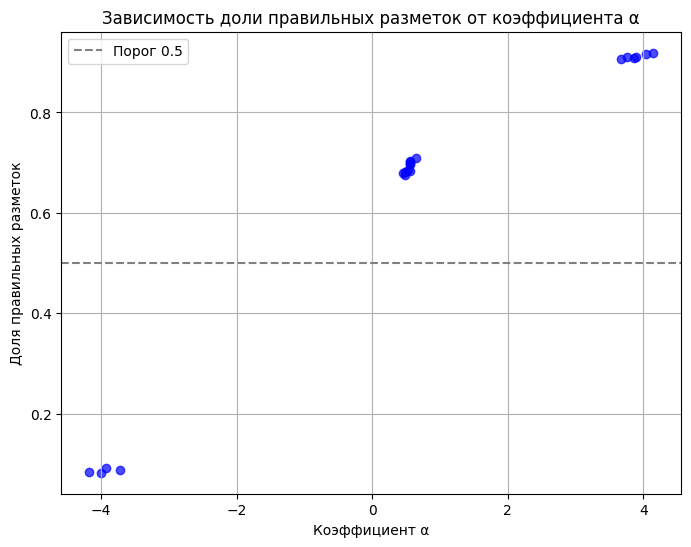

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(alpha,md, color='blue', alpha=0.7)
plt.xlabel('Коэффициент α')
plt.ylabel('Доля правильных разметок')
plt.title('Зависимость доли правильных разметок от коэффициента α')
plt.axhline(0.5, color='gray', linestyle='--', label='Порог 0.5')
plt.legend()
plt.grid(True)

Если альфа стремится к 1, то есть эксперт надёжен и даёт почти всегда правильные ответы.
Если альфа имеет большие отрицательные значения, то значит вероятность правильного ответа стремится к 0, что говорит о систематически неверных ответах. Это может означать, что эксперт путает метки или намеренно даёт неправильные ответы

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно).

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [ ]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

In [ ]:
import os
wa_files = []
for root, _, files in os.walk("/content/data/merged_data/project_syndicate"):
    wa_files.extend(os.path.join(root, file) for file in files if file.endswith(".wa"))

wa_files[:10]

['/content/data/merged_data/project_syndicate/project_syndicate_blo3.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_balkenende1.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_balibar1.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_bertram19.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_ban1.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_balcerowicz1.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_ber17.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_bck2.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa',
 '/content/data/merged_data/project_syndicate/project_syndicate_blanchard8.wa']

In [251]:
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np

@dataclass(frozen=True)
class SentencePair:
    """
    Contains lists of tokens (strings) for source and target sentence
    """
    source: List[str]
    target: List[str]


@dataclass(frozen=True)
class TokenizedSentencePair:
    """
    Contains arrays of token vocabulary indices (preferably np.int32) for source and target sentence
    """
    source_tokens: np.ndarray
    target_tokens: np.ndarray


@dataclass(frozen=True)
class LabeledAlignment:
    """
    Contains arrays of alignments (lists of tuples (source_pos, target_pos)) for a given sentence.
    Positions are numbered from 1.
    """
    sure: List[Tuple[int, int]]
    possible: List[Tuple[int, int]]

import xml.etree.ElementTree as ET

def extract_sentences(filename: str) -> Tuple[List[SentencePair], List[LabeledAlignment]]:
    """
    Given a file with tokenized parallel sentences and alignments in XML format, return a list of sentence pairs
    and alignments for each sentence.

    Args:
        filename: Name of the file containing XML markup for labeled alignments

    Returns:
        sentence_pairs: list of `SentencePair`s for each sentence in the file
        alignments: list of `LabeledAlignment`s corresponding to these sentences
    """
    with open(filename, 'r') as file:
      filedata = file.read().replace("&", "&amp;")
    root = ET.fromstring(filedata)

    sentence_pairs = []
    alignments = []
    for s in root.findall(".//s"):
        en, cs = s.find("english").text.split(), s.find("czech").text.split()
        sentence_pairs.append(SentencePair(en, cs))

        sure = [tuple(map(int, pair.split("-"))) for pair in (s.findtext("sure") or "").split()]
        possible = [tuple(map(int, pair.split("-"))) for pair in (s.findtext("possible") or "").split()]

        alignments.append(LabeledAlignment(sure, possible))

    return sentence_pairs, alignments

In [252]:
import glob
# from preprocessing import extract_sentences

dataset_path = "data/merged_data/project_syndicate"

all_sentences = []
all_targets = []

for filename in glob.glob(f"{dataset_path}/*.wa"):
    sentences, targets = extract_sentences(filename)
    all_sentences.extend(sentences)
    all_targets.extend(targets)

In [253]:
all_sentences[:1]

[SentencePair(source=['Japan', 'Is', "n't", 'Doomed'], target=['Japonsko', 'ještě', 'není', 'odsouzeno', 'k', 'zániku'])]

In [254]:
all_targets[:1]

[LabeledAlignment(sure=[(1, 1), (2, 3), (3, 3), (4, 4), (4, 5), (4, 6)], possible=[])]

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [255]:
# from collections import Counter
# mass = ['red', 'blue', 'red', 'green', 'blue', 'blue']
# cnt = Counter(mass).most_common(2)
# dict(cnt)

In [256]:
# en_counter = Counter()
# for pair in all_sentences[:2]:
#   en_counter.update(pair.source)
# en_counter = dict(en_counter.most_common(5))
# list(enumerate(en_counter))

In [257]:
from collections import Counter
def get_token_to_index(sentence_pairs: List[SentencePair], freq_cutoff=None) -> Tuple[Dict[str, int], Dict[str, int]]:
    """
    Given a parallel corpus, create two dictionaries token->index for source and target language.

    Args:
        sentence_pairs: list of `SentencePair`s for token frequency estimation
        freq_cutoff: if not None, keep only freq_cutoff most frequent tokens in each language

    Returns:
        source_dict: mapping of token to a unique number (from 0 to vocabulary size) for source language
        target_dict: mapping of token to a unique number (from 0 to vocabulary size) target language

    """
    en_counter = Counter()
    cs_counter = Counter()

    for pair in sentence_pairs:
      en_counter.update(pair.source)
      cs_counter.update(pair.target)

    if freq_cutoff: # most_common вещь норм, но тут не варик
        en_counter = dict(sorted(en_counter.items(), key=lambda x: (-x[1], x[0]))[:freq_cutoff])
        cs_counter = dict(sorted(cs_counter.items(), key=lambda x: (-x[1], x[0]))[:freq_cutoff])

    en_dict = {word: idx for idx, word in enumerate(en_counter)}
    cs_dict = {word: idx for idx, word in enumerate(cs_counter)}
    return en_dict, cs_dict


def tokenize_sents(sentence_pairs: List[SentencePair], source_dict, target_dict) -> List[TokenizedSentencePair]:
    """
    Given a parallel corpus and token_to_index for each language, transform each pair of sentences from lists
    of strings to arrays of integers. If either source or target sentence has no tokens that occur in corresponding
    token_to_index, do not include this pair in the result.

    Args:
        sentence_pairs: list of `SentencePair`s for transformation
        source_dict: mapping of token to a unique number for source language
        target_dict: mapping of token to a unique number for target language

    Returns:
        tokenized_sentence_pairs: sentences from sentence_pairs, tokenized using source_dict and target_dict
    """

    tokenizer_pairs = []

    for pair in sentence_pairs:
      en_source = [source_dict[word] for word in pair.source if word in source_dict]
      cs_source = [target_dict[word] for word in pair.target if word in target_dict]
      if en_source and cs_source:
        tokenizer_pairs.append(TokenizedSentencePair(en_source, cs_source))
    return tokenizer_pairs

In [258]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences[:3], freq_cutoff = 5)
tokenized_sentences = tokenize_sents(all_sentences[:3], t_idx_src, t_idx_tgt)
tokenized_sentences

[TokenizedSentencePair(source_tokens=[0], target_tokens=[4]),
 TokenizedSentencePair(source_tokens=[4], target_tokens=[3]),
 TokenizedSentencePair(source_tokens=[2, 3, 0, 1], target_tokens=[1, 2, 0])]

In [259]:
get_token_to_index(all_sentences[:2])

({'Japan': 0, 'Is': 1, "n't": 2, 'Doomed': 3, 'Magnus': 4, 'Blomstrom': 5},
 {'Japonsko': 0,
  'ještě': 1,
  'není': 2,
  'odsouzeno': 3,
  'k': 4,
  'zániku': 5,
  'Magnus': 6,
  'Blomstrom': 7})

In [260]:
all_sentences[:1]

[SentencePair(source=['Japan', 'Is', "n't", 'Doomed'], target=['Japonsko', 'ještě', 'není', 'odsouzeno', 'k', 'zániku'])]

In [261]:
all_targets[:1]

[LabeledAlignment(sure=[(1, 1), (2, 3), (3, 3), (4, 4), (4, 5), (4, 6)], possible=[])]

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности.

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [245]:
from abc import ABC, abstractmethod
from itertools import product
from typing import List, Tuple

import numpy as np

# from preprocessing import TokenizedSentencePair


class BaseAligner(ABC):
    """
    Describes a public interface for word alignment models.
    """

    @abstractmethod
    def fit(self, parallel_corpus: List[TokenizedSentencePair]):
        """
        Estimate alignment model parameters from a collection of parallel sentences.

        Args:
            parallel_corpus: list of sentences with translations, given as numpy arrays of vocabulary indices

        Returns:
        """
        pass

    @abstractmethod
    def align(self, sentences: List[TokenizedSentencePair]) -> List[List[Tuple[int, int]]]:
        """
        Given a list of tokenized sentences, predict alignments of source and target words.

        Args:
            sentences: list of sentences with translations, given as numpy arrays of vocabulary indices

        Returns:
            alignments: list of alignments for each sentence pair, i.e. lists of tuples (source_pos, target_pos).
            Alignment positions in sentences start from 1.
        """
        pass

In [248]:
class DiceAligner(BaseAligner):
    def __init__(self, num_source_words: int, num_target_words: int, threshold=0.5):
        self.cooc = np.zeros((num_source_words, num_target_words), dtype=np.uint32)
        self.dice_scores = None
        self.threshold = threshold

    def fit(self, parallel_corpus):
        for sentence in parallel_corpus:
            # use np.unique, because for a pair of words we add 1 only once for each sentence
            for source_token in np.unique(sentence.source_tokens):
                for target_token in np.unique(sentence.target_tokens):
                    self.cooc[source_token, target_token] += 1
        self.dice_scores = (2 * self.cooc.astype(np.float32) /
                            (self.cooc.sum(0, keepdims=True) + self.cooc.sum(1, keepdims=True)))

    def align(self, sentences):
        result = []
        for sentence in sentences:
            alignment = []
            for (i, source_token), (j, target_token) in product(
                    enumerate(sentence.source_tokens, 1),
                    enumerate(sentence.target_tokens, 1)):
                if self.dice_scores[source_token, target_token] > self.threshold:
                    alignment.append((i, j))
            result.append(alignment)
        return result

In [250]:
# from models import DiceAligner
baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая.

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели.

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [264]:
from typing import List, Tuple

# from preprocessing import LabeledAlignment


def compute_precision(reference: List[LabeledAlignment], predicted: List[List[Tuple[int, int]]]) -> Tuple[int, int]:
    """
    Computes the numerator and the denominator of the precision for predicted alignments.
    Numerator : |predicted and possible|
    Denominator: |predicted|
    Note that for correct metric values `sure` needs to be a subset of `possible`, but it is not the case for input data.

    Args:
        reference: list of alignments with fields `possible` and `sure`
        predicted: list of alignments, i.e. lists of tuples (source_pos, target_pos)

    Returns:
        intersection: number of alignments that are both in predicted and possible sets, summed over all sentences
        total_predicted: total number of predicted alignments over all sentences
    """
    correct = 0
    total_pred = 0
    for ref, pred in zip(reference, predicted):
        for pair in pred:
            if pair in ref.possible:
                correct += 1
        total_pred += len(pred)

    if total_pred == 0:
        return 0
    return correct / total_pred

def compute_recall(reference: List[LabeledAlignment], predicted: List[List[Tuple[int, int]]]) -> Tuple[int, int]:
    """
    Computes the numerator and the denominator of the recall for predicted alignments.
    Numerator : |predicted and sure|
    Denominator: |sure|

    Args:
        reference: list of alignments with fields `possible` and `sure`
        predicted: list of alignments, i.e. lists of tuples (source_pos, target_pos)

    Returns:
        intersection: number of alignments that are both in predicted and sure sets, summed over all sentences
        total_predicted: total number of sure alignments over all sentences
    """
    correct = 0
    total_sure = 0
    for ref, pred in zip(reference, predicted):
        for pair in pred:
            if pair in ref.sure:
                correct += 1
        total_sure += len(ref.sure)

    if total_sure == 0:
        return 0
    return correct / total_sure

def compute_aer(reference: List[LabeledAlignment], predicted: List[List[Tuple[int, int]]]) -> float:
    """
    Computes the alignment error rate for predictions.
    AER=1-(|predicted and possible|+|predicted and sure|)/(|predicted|+|sure|)
    Please use compute_precision and compute_recall to reduce code duplication.

    Args:
        reference: list of alignments with fields `possible` and `sure`
        predicted: list of alignments, i.e. lists of tuples (source_pos, target_pos)

    Returns:
        aer: the alignment error rate
    """
    precision = compute_precision(reference, predicted)
    recall = compute_recall(reference, predicted)
    total = precision + recall
    if total == 0:
        return 0
    return 1 - total

In [265]:
# from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.75

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

(∩｀-´)⊃━☆ﾟ.*･｡ﾟ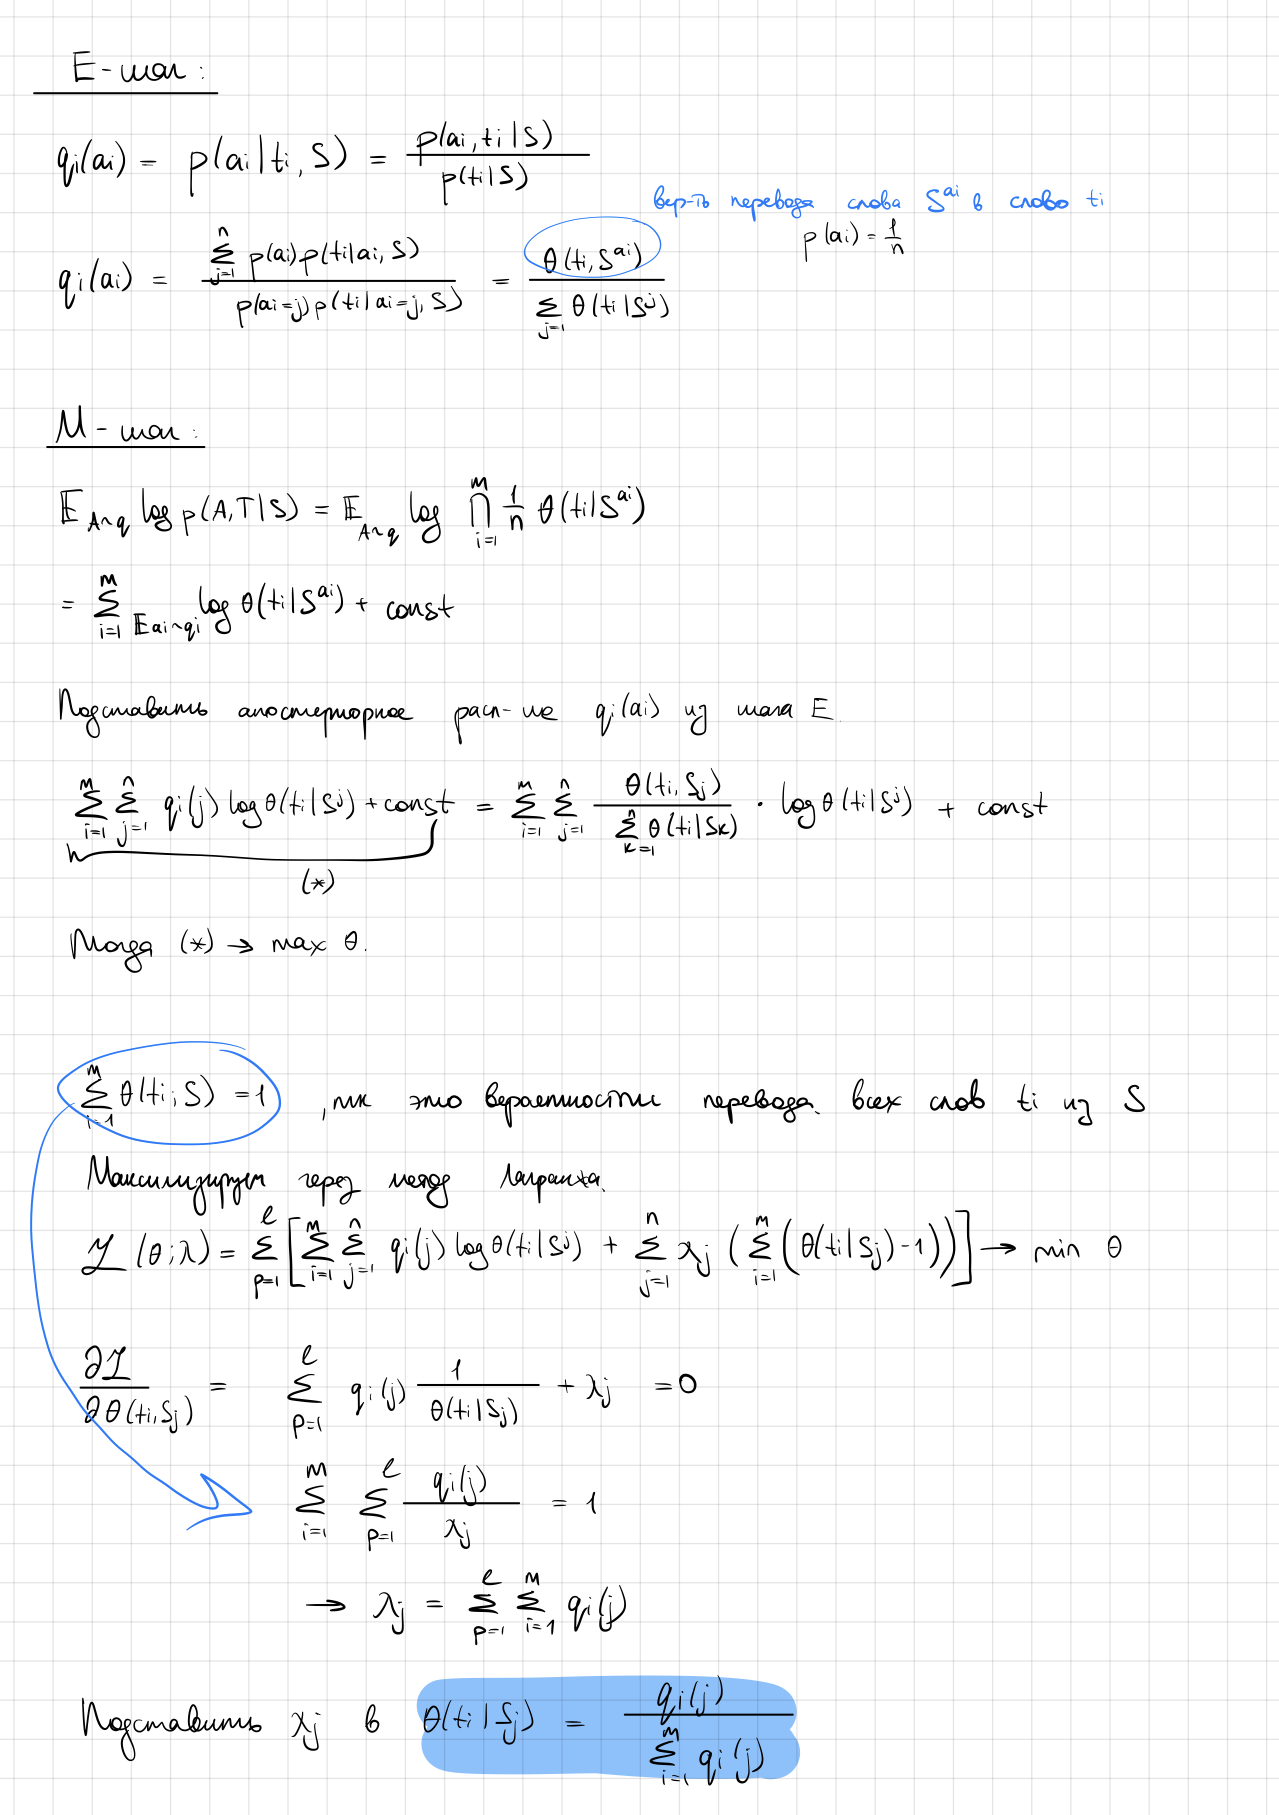

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

In [ ]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences);

# ༼つ ಠ益ಠ༽つ ─=≡ΣO))

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [ ]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [ ]:
# (>ω<)ノ—==ΞΞ☆*✲ﾟ

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [ ]:
# (•̀ 3 •́)━★☆.*･｡ﾟ

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

ଘ(๑˃̵ᴗ˂̵)━☆ﾟ.*･｡ﾟ

**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

In [ ]:
from models import WordPositionAligner
# (≧ ◡ ≦)━★☆.*･｡ﾟ

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [ ]:
# (੭•̀ω•́)੭̸*✩⁺˚

**Задание 7. (бонус, до 3 баллов)**

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ